# Metaheuristic with Original Inputs:



In [1]:
#  Imports
from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle
from src.scenes import HMProblemScene
import build_data
from build_data import ext_pyomo_vals
import numpy as np
import matplotlib.pyplot as plt
import copy

# Ignore the warnings (only demonstration purposes!)
import warnings
warnings.filterwarnings("ignore")

### Defining set up variables, important to get the data from mysql db.

In [2]:
# Set up variables 

_specific_date='2019-11-06' # -> Change date
_time_step = 60 # -> Change time step
_update_forecast = False # -> True to have forecast updat in the operation
_save_plots = True # -> True to save the plots

#Comentarios sobre performance de dias
#Dia 6 corre rapido
#ao fim do dia 13 as previsões sao maiores do q o consumo real
#dia 16/17 é um exemplo de uma pessima previsão

# Method 1 - Forecast Data:

In this method, it is used the data from mysql forecast databases as input for load and generators.

In [3]:
# Data parsing
method_obj_1 = build_data.Data(_file_path='data/EC_V4_new_UC1.xlsx', ec_id=1) 

In [4]:
method_obj_1.data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

In [5]:
method1_folder = "./input_data/method1"

# Define generators
gens1 = Generator(name='gens',
                 value=np.zeros(method_obj_1.data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(method_obj_1.data.generator['p_forecast'].shape),
                 upper_bound=method_obj_1.data.generator['p_forecast'],
                 cost=method_obj_1.data.generator['cost_parameter_b'],
                 cost_nde=method_obj_1.data.generator['cost_nde'],
                 is_renewable=method_obj_1.data.generator['type_generator'])

method_obj_1.get_data_from_db(specific_date=_specific_date, table="generators_forecast", end = 24*60//_time_step, experiment_id = 17, time_step=_time_step, folder=method1_folder, save=True)


# Define loads
loads1 = Load(name='loads',
             value=method_obj_1.data.load['p_forecast'],
             lower_bound=np.zeros(method_obj_1.data.load['p_forecast'].shape),
             upper_bound=method_obj_1.data.load['p_forecast'],
             cost=np.ones(method_obj_1.data.load['p_forecast'].shape),
             cost_cut=method_obj_1.data.load['cost_cut'],
             cost_reduce=method_obj_1.data.load['cost_reduce'],
             cost_ens=method_obj_1.data.load['cost_ens'])


method_obj_1.get_data_from_db(specific_date=_specific_date, table="loads_forecast", end = 24*60//_time_step, experiment_id = 23, time_step=_time_step, folder=method1_folder, save=True)

# Define storage
stor1 = Storage(name='stor',
               value=np.zeros(method_obj_1.data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(method_obj_1.data.storage['p_charge_limit'].shape),
               upper_bound=(method_obj_1.data.storage['energy_capacity'] *
                            np.ones(method_obj_1.data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(method_obj_1.data.storage['p_charge_limit'].shape),
               cost_discharge=method_obj_1.data.storage['discharge_price'],
               cost_charge=method_obj_1.data.storage['charge_price'],
               capacity_max=method_obj_1.data.storage['energy_capacity'],
               capacity_min=method_obj_1.data.storage['energy_min_percentage'],
               initial_charge=method_obj_1.data.storage['initial_state'],
               discharge_efficiency=method_obj_1.data.storage['discharge_efficiency'],
               discharge_max=method_obj_1.data.storage['p_discharge_limit'],
               charge_efficiency=method_obj_1.data.storage['charge_efficiency'],
               charge_max=method_obj_1.data.storage['p_charge_limit'],
               #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
               #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
               capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
stor1.to_json(path=method1_folder)

# Define vehicle to grid
v2g1 = Vehicle(name='evs',
              value=np.zeros(method_obj_1.data.vehicle['schedule_charge'].shape),
              lower_bound=(method_obj_1.data.vehicle['e_capacity_max'] * method_obj_1.data.vehicle['min_technical_soc'] *
                           np.ones(method_obj_1.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(method_obj_1.data.vehicle['e_capacity_max'] * np.ones(method_obj_1.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(method_obj_1.data.vehicle['schedule_charge'].shape),
              cost_discharge=method_obj_1.data.vehicle['discharge_price'][:, 0],
              cost_charge=method_obj_1.data.vehicle['charge_price'][:, 0],
              capacity_max=method_obj_1.data.vehicle['e_capacity_max'],
              initial_charge=np.ones(method_obj_1.data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=method_obj_1.data.vehicle['min_technical_soc'],
              discharge_efficiency=method_obj_1.data.vehicle['discharge_efficiency'],
              charge_efficiency=method_obj_1.data.vehicle['charge_efficiency'],
              #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
              #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
              schedule_discharge=method_obj_1.data.vehicle['schedule_discharge'],
              schedule_charge=method_obj_1.data.vehicle['schedule_charge'])
v2g1.to_json(path=method1_folder)

# Define imports and exports
pimp1 = BinaryResource(name='pImp',
                      value=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_1.data.peers['import_contracted_p_max'][0, :],
                      cost=method_obj_1.data.peers['buy_price'][0, :],
                      is_active=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape))
pimp1.to_json(path=method1_folder)

pexp1 = BinaryResource(name='pExp',
                      value=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_1.data.peers['export_contracted_p_max'][0, :],
                      cost=method_obj_1.data.peers['sell_price'][0, :],
                      is_active=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape))
pexp1.to_json(path=method1_folder)

# Establish the components
ec_components = {'gen': gens1,
                 'loads': loads1,
                 'stor': stor1,
                 'evs': v2g1,
                 'pimp': pimp1,
                 'pexp': pexp1}

ec_components

{'gen': gens,
 'loads': loads,
 'stor': stor,
 'evs': evs,
 'pimp': pImp,
 'pexp': pExp}

In [6]:
# Create the scene

scene = HMProblemScene(name='EC1', data=ec_components, hm_parser=method_obj_1.data, pop_size=20,
                       n_iter=10000, iter_tolerance=1000)
scene.initialize()
scene.run()

100%|██████████| 10000/10000 [08:21<00:00, 19.95it/s]


In [7]:
scene.to_json(path="./results/method_1", filename="scene1_results")

In [8]:
scene.current_best.keys()

dict_keys(['genActPower', 'genExcActPower', 'pImp', 'pExp', 'loadRedActPower', 'loadCutActPower', 'loadENS', 'storDchActPower', 'storChActPower', 'EminRelaxStor', 'storEnerState', 'v2gDchActPower', 'v2gChActPower', 'EminRelaxEV', 'v2gEnerState', 'genXo', 'loadXo', 'storDchXo', 'storChXo', 'v2gDchXo', 'v2gChXo'])

In [9]:
scene.exporting_results()

In [10]:
scene.export_profile_to_excel(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads1.value,
                              name="profile_data_1.xlsx", path="results/method_1"
                              )

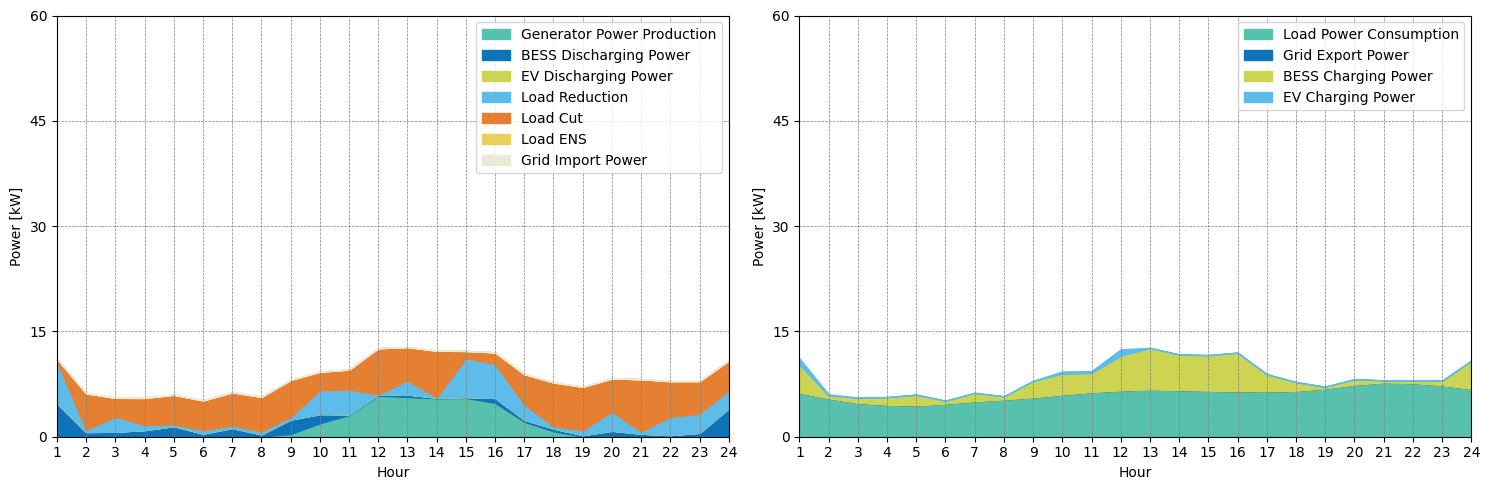

In [11]:
scene.plot(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads1.value,
                              name="profile_data_1", path="plots/method_1", graph_max=40, graph_step=10)

In [12]:
#scene.components['evs'].capital_cost
v2g1.cost_discharge

array([0.05, 0.06, 0.05, 0.05, 0.06, 0.06, 0.06], dtype=object)

In [13]:
# Sum matrices along the columns

scene.algo.population_fitness

[90.02341788051798,
 90.0267352285023,
 90.26886083051447,
 90.08378563251716,
 89.95202293095541,
 90.04899145350375,
 90.3256316484683,
 90.03485202746755,
 90.06274695132353,
 90.11409495120046,
 90.14714881302775,
 90.03746196739905,
 90.01931412666349,
 90.02308106957219,
 90.03778591176845,
 90.04902722057638,
 90.02199417314033,
 90.01485562107978,
 90.07184246579796,
 90.04769760855548]

In [14]:
 # Check the population

scene.algo.population

array([[1.14686542e-02, 1.16019812e-02, 1.60844226e-03, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.17994599e-02, 1.16019812e-02, 1.87389617e-03, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.04793892e-02, 1.06758193e-02, 6.35710531e-04, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [1.08831764e-02, 1.15828229e-02, 4.25109575e-04, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.20091929e-02, 1.15057617e-02, 1.01062820e-03, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.18710796e-02, 1.15401360e-02, 1.70297295e-03, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

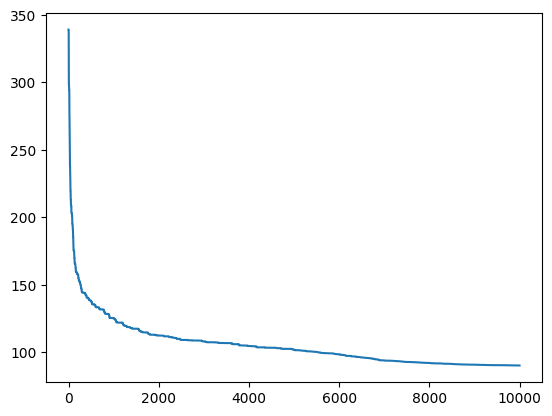

In [15]:
plt.plot(scene.algo.population_history_fitness)

In [16]:
scene.algo.population_history_fitness

[339.29917996580105,
 339.29917996580105,
 316.1708863224405,
 298.62361967484964,
 298.62361967484964,
 298.62361967484964,
 298.62361967484964,
 298.62361967484964,
 297.0662207533768,
 297.0662207533768,
 297.0662207533768,
 294.32835204934236,
 294.32835204934236,
 294.32835204934236,
 294.32835204934236,
 285.9657477660941,
 285.9657477660941,
 274.77732763419596,
 274.77732763419596,
 273.52282005454805,
 271.4986937158425,
 261.01870715571243,
 261.01870715571243,
 260.94268476971024,
 256.53698361865304,
 256.53698361865304,
 253.49288799177927,
 245.93973846528576,
 237.84344068504475,
 237.84344068504475,
 237.84344068504475,
 237.84344068504475,
 237.84344068504475,
 231.0298791924416,
 231.0298791924416,
 231.0298791924416,
 230.7101586454854,
 227.46313100221957,
 219.6882115754828,
 219.6882115754828,
 219.6882115754828,
 219.6882115754828,
 219.6882115754828,
 219.29513818585878,
 215.22631602003855,
 215.22631602003855,
 212.746781682212,
 212.746781682212,
 212.7467816

In [17]:
scene.algo.population_fitness

[90.02341788051798,
 90.0267352285023,
 90.26886083051447,
 90.08378563251716,
 89.95202293095541,
 90.04899145350375,
 90.3256316484683,
 90.03485202746755,
 90.06274695132353,
 90.11409495120046,
 90.14714881302775,
 90.03746196739905,
 90.01931412666349,
 90.02308106957219,
 90.03778591176845,
 90.04902722057638,
 90.02199417314033,
 90.01485562107978,
 90.07184246579796,
 90.04769760855548]

In [18]:
scene.current_best_fitness

90.02851081767197

# Method 2 - Real Data

In [19]:
# Data parsing
method_obj_2 = build_data.Data(_file_path='data/EC_V4_new_UC1.xlsx', ec_id=1) 

In [20]:
method_obj_2.data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

In [21]:
method2_folder = "./input_data/method2"

# Define generators
gens2 = Generator(name='gens2',
                 value=np.zeros(method_obj_2.data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(method_obj_2.data.generator['p_forecast'].shape),
                 upper_bound=method_obj_2.data.generator['p_forecast'],
                 cost=method_obj_2.data.generator['cost_parameter_b'],
                 cost_nde=method_obj_2.data.generator['cost_nde'],
                 is_renewable=method_obj_2.data.generator['type_generator'])

method_obj_2.get_data_from_db(specific_date=_specific_date, table="generators", end = 24*60//_time_step, 
                             time_step=_time_step, folder=method2_folder, save=True)


# Define loads
loads2 = Load(name='loads2',
             value=method_obj_2.data.load['p_forecast'],
             lower_bound=np.zeros(method_obj_2.data.load['p_forecast'].shape),
             upper_bound=method_obj_2.data.load['p_forecast'],
             cost=np.ones(method_obj_2.data.load['p_forecast'].shape),
             cost_cut=method_obj_2.data.load['cost_cut'],
             cost_reduce=method_obj_2.data.load['cost_reduce'],
             cost_ens=method_obj_2.data.load['cost_ens'])


method_obj_2.get_data_from_db(specific_date=_specific_date, table="loads", end = 24*60//_time_step, 
                            time_step=_time_step, folder=method2_folder, save=True)

# Define storage
stor2 = Storage(name='stor2',
               value=np.zeros(method_obj_2.data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(method_obj_2.data.storage['p_charge_limit'].shape),
               upper_bound=(method_obj_2.data.storage['energy_capacity'] *
                            np.ones(method_obj_2.data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(method_obj_2.data.storage['p_charge_limit'].shape),
               cost_discharge=method_obj_2.data.storage['discharge_price'],
               cost_charge=method_obj_2.data.storage['charge_price'],
               capacity_max=method_obj_2.data.storage['energy_capacity'],
               capacity_min=method_obj_2.data.storage['energy_min_percentage'],
               initial_charge=method_obj_2.data.storage['initial_state'],
               discharge_efficiency=method_obj_2.data.storage['discharge_efficiency'],
               discharge_max=method_obj_2.data.storage['p_discharge_limit'],
               charge_efficiency=method_obj_2.data.storage['charge_efficiency'],
               charge_max=method_obj_2.data.storage['p_charge_limit'],
               #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
               #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
               capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
stor2.to_json(path=method2_folder)

# Define vehicle to grid
v2g2 = Vehicle(name='evs2',
              value=np.zeros(method_obj_2.data.vehicle['schedule_charge'].shape),
              lower_bound=(method_obj_2.data.vehicle['e_capacity_max'] * method_obj_2.data.vehicle['min_technical_soc'] *
                           np.ones(method_obj_2.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(method_obj_2.data.vehicle['e_capacity_max'] * np.ones(method_obj_2.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(method_obj_2.data.vehicle['schedule_charge'].shape),
              cost_discharge=method_obj_2.data.vehicle['discharge_price'][:, 0],
              cost_charge=method_obj_2.data.vehicle['charge_price'][:, 0],
              capacity_max=method_obj_2.data.vehicle['e_capacity_max'],
              initial_charge=np.ones(method_obj_2.data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=method_obj_2.data.vehicle['min_technical_soc'],
              discharge_efficiency=method_obj_2.data.vehicle['discharge_efficiency'],
              charge_efficiency=method_obj_2.data.vehicle['charge_efficiency'],
              #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
              #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
              schedule_discharge=method_obj_2.data.vehicle['schedule_discharge'],
              schedule_charge=method_obj_2.data.vehicle['schedule_charge'])
v2g2.to_json(path=method2_folder)

# Define imports and exports
pimp2 = BinaryResource(name='pImp2',
                      value=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_2.data.peers['import_contracted_p_max'][0, :],
                      cost=method_obj_2.data.peers['buy_price'][0, :],
                      is_active=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape))
pimp2.to_json(path=method2_folder)

pexp2 = BinaryResource(name='pExp2',
                      value=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_2.data.peers['export_contracted_p_max'][0, :],
                      cost=method_obj_2.data.peers['sell_price'][0, :],
                      is_active=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape))
pexp2.to_json(path=method2_folder)

# Establish the components
ec_components = {'gen': gens2,
                 'loads': loads2,
                 'stor': stor2,
                 'evs': v2g2,
                 'pimp': pimp2,
                 'pexp': pexp2}

ec_components

{'gen': gens,
 'loads': loads,
 'stor': stor,
 'evs': evs,
 'pimp': pImp,
 'pexp': pExp}

In [22]:
# Create the scene

scene2 = HMProblemScene(name='EC2', data=ec_components, hm_parser=method_obj_2.data, pop_size=20,
                       n_iter=10000, iter_tolerance=1000)
scene2.initialize()
scene2.run()

100%|██████████| 10000/10000 [08:18<00:00, 20.07it/s]


In [23]:
scene2.to_json(path="./results/method_2", filename="scene2_results")

In [24]:
scene2.current_best.keys()

dict_keys(['genActPower', 'genExcActPower', 'pImp', 'pExp', 'loadRedActPower', 'loadCutActPower', 'loadENS', 'storDchActPower', 'storChActPower', 'EminRelaxStor', 'storEnerState', 'v2gDchActPower', 'v2gChActPower', 'EminRelaxEV', 'v2gEnerState', 'genXo', 'loadXo', 'storDchXo', 'storChXo', 'v2gDchXo', 'v2gChXo'])

In [25]:
scene2.exporting_results()

In [46]:
scene2.export_profile_to_excel(scene2.current_best['genActPower'], scene2.current_best['storDchActPower'],
                              scene2.current_best['v2gDchActPower'], scene2.current_best['loadRedActPower'],
                              scene2.current_best['loadCutActPower'], scene2.current_best['loadENS'],
                              scene2.current_best['pImp'], scene2.current_best['genExcActPower'],
                              scene2.current_best['storChActPower'], scene2.current_best['v2gChActPower'],
                              loads2.value,
                              name="profile_data_2.xlsx", path="results/method_2"
                              )

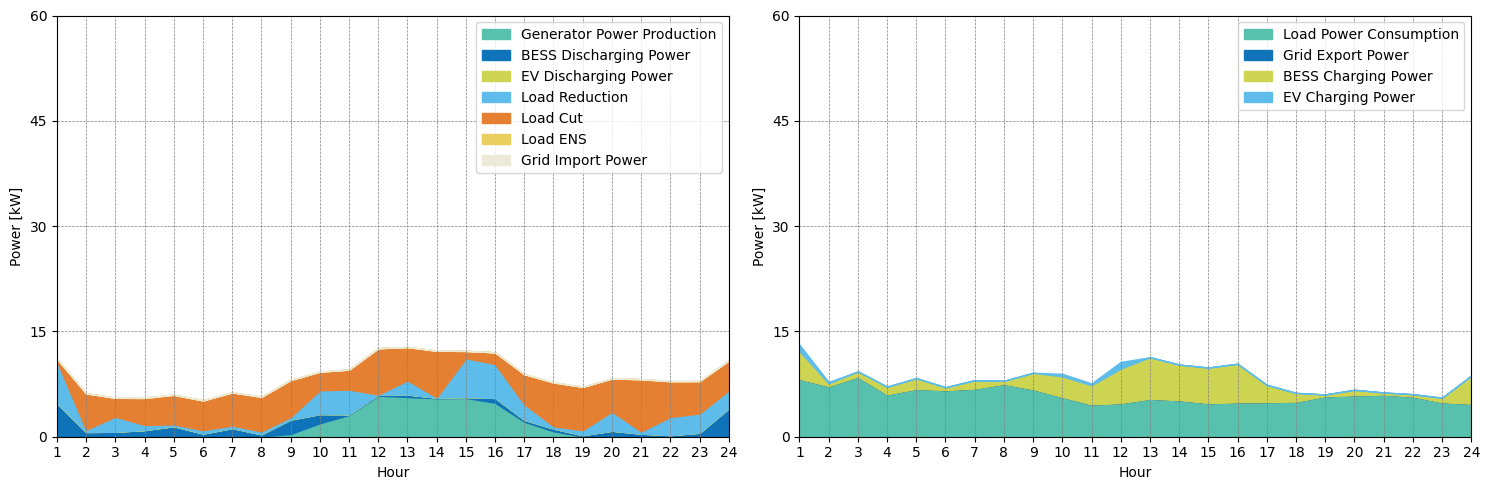

In [27]:
scene2.plot(scene2.current_best['genActPower'], scene2.current_best['storDchActPower'],
                              scene2.current_best['v2gDchActPower'], scene2.current_best['loadRedActPower'],
                              scene2.current_best['loadCutActPower'], scene2.current_best['loadENS'],
                              scene2.current_best['pImp'], scene2.current_best['genExcActPower'],
                              scene2.current_best['storChActPower'], scene2.current_best['v2gChActPower'],
                              loads2.value,
                              name="profile_data_2", path="plots/method_2", graph_max=40, graph_step=10)

In [28]:
#scene.components['evs'].capital_cost
v2g2.cost_discharge

array([0.05, 0.06, 0.05, 0.05, 0.06, 0.06, 0.06], dtype=object)

In [29]:
# Sum matrices along the columns

scene2.algo.population_fitness

[90.32132176750477,
 90.5336832459852,
 89.98323906519667,
 90.53130663254974,
 89.73855911477997,
 89.54753390073628,
 89.77128714098687,
 90.16804093923155,
 89.67322023536701,
 89.6185664751609,
 89.71461051771252,
 89.54943439909147,
 91.07385710676715,
 89.71674390250044,
 91.72435072842778,
 90.22480584615418,
 90.42041550553854,
 90.37035532967381,
 90.51638573448709,
 90.19546285289141]

In [30]:
 # Check the population

scene2.algo.population

array([[7.96853283e-010, 1.01178548e-008, 1.01178548e-008, ...,
        1.00000000e+000, 0.00000000e+000, 1.00000000e+000],
       [2.20085022e-009, 7.13235467e-009, 7.59485858e-009, ...,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [7.86994571e-009, 9.86995435e-105, 1.46289827e-009, ...,
        1.00000000e+000, 0.00000000e+000, 1.00000000e+000],
       ...,
       [9.90847655e-010, 0.00000000e+000, 0.00000000e+000, ...,
        1.00000000e+000, 0.00000000e+000, 1.00000000e+000],
       [6.96242826e-010, 9.33048236e-010, 0.00000000e+000, ...,
        1.00000000e+000, 0.00000000e+000, 1.00000000e+000],
       [1.76375039e-009, 2.03840462e-009, 9.27664964e-009, ...,
        1.00000000e+000, 0.00000000e+000, 1.00000000e+000]])

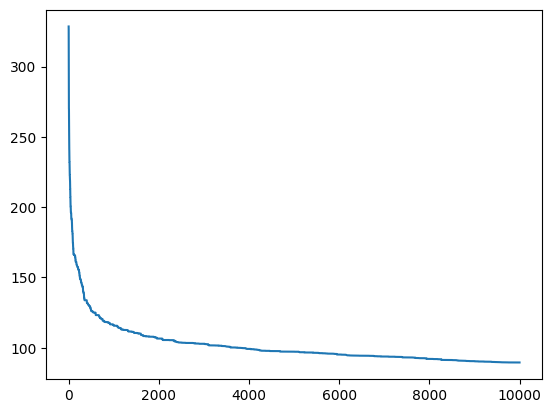

In [31]:
plt.plot(scene2.algo.population_history_fitness)

In [32]:
scene2.algo.population_history_fitness

[328.5414285245669,
 326.55027108425674,
 304.973945225486,
 298.9278097294275,
 280.9482649972951,
 280.9482649972951,
 270.1634086652357,
 269.84083812444106,
 266.5551328144914,
 261.0629714761934,
 252.41972995518415,
 252.22348038927373,
 241.1972181065476,
 241.1972181065476,
 241.1972181065476,
 240.11719255355248,
 233.63004334290255,
 232.0130944005481,
 232.0130944005481,
 232.0130944005481,
 232.0130944005481,
 228.95090979636788,
 226.63221806453666,
 226.59260387451977,
 222.89054511813177,
 222.89054511813177,
 222.89054511813177,
 221.34696017648835,
 221.25793329856313,
 219.0010802124226,
 219.0010802124226,
 219.0010802124226,
 214.1810419795339,
 214.1810419795339,
 213.10719544159497,
 213.10719544159497,
 207.12659318790642,
 207.12659318790642,
 207.12659318790642,
 207.12659318790642,
 204.27389993290677,
 200.43647388834495,
 200.43647388834495,
 200.43647388834495,
 200.43647388834495,
 200.43647388834495,
 200.43647388834495,
 198.5690844638278,
 197.460876523

In [33]:
scene2.algo.population_fitness

[90.32132176750477,
 90.5336832459852,
 89.98323906519667,
 90.53130663254974,
 89.73855911477997,
 89.54753390073628,
 89.77128714098687,
 90.16804093923155,
 89.67322023536701,
 89.6185664751609,
 89.71461051771252,
 89.54943439909147,
 91.07385710676715,
 89.71674390250044,
 91.72435072842778,
 90.22480584615418,
 90.42041550553854,
 90.37035532967381,
 90.51638573448709,
 90.19546285289141]

In [34]:
scene2.current_best_fitness

89.83314441616933

# Method 3 - Forecast + Real Data

In [35]:
# Data parsing
method_obj_3 = build_data.Data(_file_path='data/EC_V4_new_UC1.xlsx', ec_id=1) 

In [36]:
method_obj_3.data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

In [37]:
method3_folder = "./input_data/method3"

# Define generators
gens3 = Generator(name='gens3',
                 value=np.zeros(method_obj_3.data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(method_obj_3.data.generator['p_forecast'].shape),
                 upper_bound=method_obj_3.data.generator['p_forecast'],
                 cost=method_obj_3.data.generator['cost_parameter_b'],
                 cost_nde=method_obj_3.data.generator['cost_nde'],
                 is_renewable=method_obj_3.data.generator['type_generator'])

method_obj_3.get_data_from_db(specific_date=_specific_date, table="generators", end = 24*60//_time_step, 
                             time_step=_time_step, folder=method3_folder, save=True)


# Define loads
loads3 = Load(name='loads3',
             value=method_obj_3.data.load['p_forecast'],
             lower_bound=np.zeros(method_obj_3.data.load['p_forecast'].shape),
             upper_bound=method_obj_3.data.load['p_forecast'],
             cost=np.ones(method_obj_3.data.load['p_forecast'].shape),
             cost_cut=method_obj_3.data.load['cost_cut'],
             cost_reduce=method_obj_3.data.load['cost_reduce'],
             cost_ens=method_obj_3.data.load['cost_ens'])


method_obj_3.get_data_from_db(specific_date=_specific_date, table="loads", end = 24*60//_time_step, 
                            time_step=_time_step, folder=method2_folder, save=True)

# Define storage
stor3 = Storage(name='stor3',
               value=np.zeros(method_obj_3.data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(method_obj_3.data.storage['p_charge_limit'].shape),
               upper_bound=(method_obj_3.data.storage['energy_capacity'] *
                            np.ones(method_obj_3.data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(method_obj_3.data.storage['p_charge_limit'].shape),
               cost_discharge=method_obj_3.data.storage['discharge_price'],
               cost_charge=method_obj_3.data.storage['charge_price'],
               capacity_max=method_obj_3.data.storage['energy_capacity'],
               capacity_min=method_obj_3.data.storage['energy_min_percentage'],
               initial_charge=method_obj_3.data.storage['initial_state'],
               discharge_efficiency=method_obj_3.data.storage['discharge_efficiency'],
               discharge_max=method_obj_3.data.storage['p_discharge_limit'],
               charge_efficiency=method_obj_3.data.storage['charge_efficiency'],
               charge_max=method_obj_3.data.storage['p_charge_limit'],
               #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
               #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
               capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
stor3.to_json(path=method2_folder)

# Define vehicle to grid
v2g3 = Vehicle(name='evs3',
              value=np.zeros(method_obj_3.data.vehicle['schedule_charge'].shape),
              lower_bound=(method_obj_3.data.vehicle['e_capacity_max'] * method_obj_3.data.vehicle['min_technical_soc'] *
                           np.ones(method_obj_3.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(method_obj_3.data.vehicle['e_capacity_max'] * np.ones(method_obj_3.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(method_obj_3.data.vehicle['schedule_charge'].shape),
              cost_discharge=method_obj_3.data.vehicle['discharge_price'][:, 0],
              cost_charge=method_obj_3.data.vehicle['charge_price'][:, 0],
              capacity_max=method_obj_3.data.vehicle['e_capacity_max'],
              initial_charge=np.ones(method_obj_3.data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=method_obj_3.data.vehicle['min_technical_soc'],
              discharge_efficiency=method_obj_3.data.vehicle['discharge_efficiency'],
              charge_efficiency=method_obj_3.data.vehicle['charge_efficiency'],
              #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
              #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
              schedule_discharge=method_obj_3.data.vehicle['schedule_discharge'],
              schedule_charge=method_obj_3.data.vehicle['schedule_charge'])
v2g3.to_json(path=method2_folder)

# Define imports and exports
pimp3 = BinaryResource(name='pImp3',
                      value=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_3.data.peers['import_contracted_p_max'][0, :],
                      cost=method_obj_3.data.peers['buy_price'][0, :],
                      is_active=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape))
pimp3.to_json(path=method2_folder)

pexp3 = BinaryResource(name='pExp3',
                      value=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_3.data.peers['export_contracted_p_max'][0, :],
                      cost=method_obj_3.data.peers['sell_price'][0, :],
                      is_active=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape))
pexp3.to_json(path=method2_folder)

# Establish the components
ec_components = {'gen': gens3,
                 'loads': loads3,
                 'stor': stor3,
                 'evs': v2g3,
                 'pimp': pimp3,
                 'pexp': pexp3}

ec_components

{'gen': gens,
 'loads': loads,
 'stor': stor,
 'evs': evs,
 'pimp': pImp,
 'pexp': pExp}

In [38]:
# Create the scene

scene3 = HMProblemScene(name='EC3', data=ec_components, hm_parser=method_obj_3.data, pop_size=20,
                       n_iter=10000, iter_tolerance=1000)
scene3.initialize()
scene3.run()

100%|██████████| 10000/10000 [08:35<00:00, 19.40it/s]


In [39]:
scene3.current_best.keys()

dict_keys(['genActPower', 'genExcActPower', 'pImp', 'pExp', 'loadRedActPower', 'loadCutActPower', 'loadENS', 'storDchActPower', 'storChActPower', 'EminRelaxStor', 'storEnerState', 'v2gDchActPower', 'v2gChActPower', 'EminRelaxEV', 'v2gEnerState', 'genXo', 'loadXo', 'storDchXo', 'storChXo', 'v2gDchXo', 'v2gChXo'])

In [40]:
scene3.exporting_results()

In [44]:
scene3.export_profile_to_excel(scene3.current_best['genActPower'], scene3.current_best['storDchActPower'],
                              scene3.current_best['v2gDchActPower'], scene3.current_best['loadRedActPower'],
                              scene3.current_best['loadCutActPower'], scene3.current_best['loadENS'],
                              scene3.current_best['pImp'], scene3.current_best['genExcActPower'],
                              scene3.current_best['storChActPower'], scene3.current_best['v2gChActPower'],
                              loads3.value,
                              name="profile_data_3.xlsx", path="results/method_3"
                              )

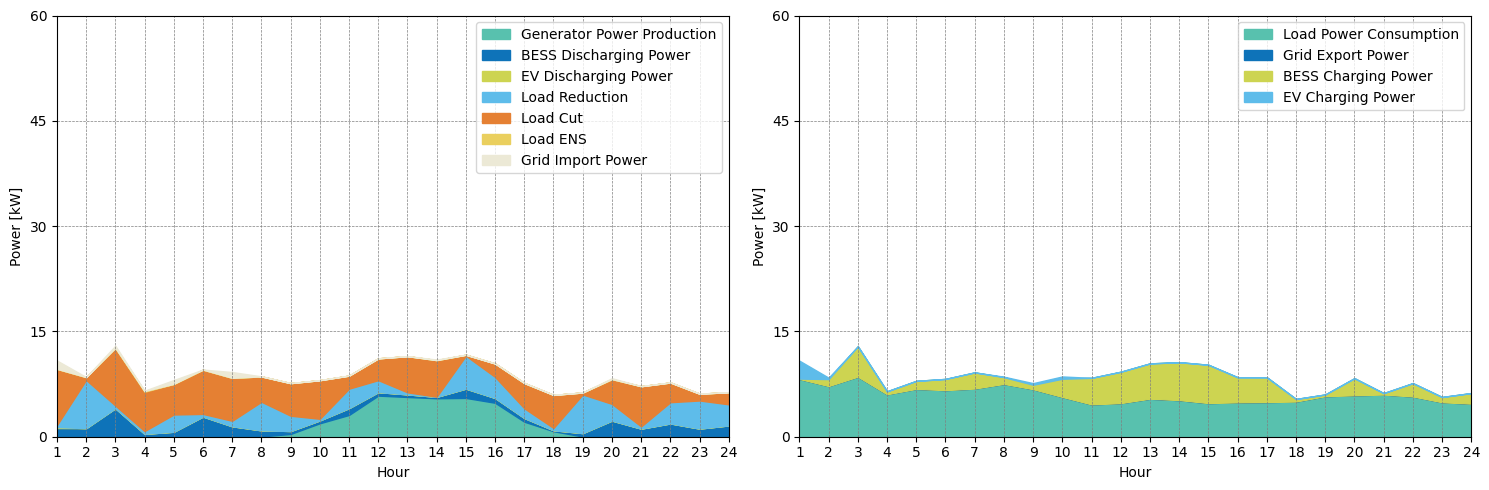

In [45]:
scene3.plot(scene.current_best['genActPower'], scene3.current_best['storDchActPower'],
                              scene3.current_best['v2gDchActPower'], scene3.current_best['loadRedActPower'],
                              scene3.current_best['loadCutActPower'], scene3.current_best['loadENS'],
                              scene3.current_best['pImp'], scene3.current_best['genExcActPower'],
                              scene3.current_best['storChActPower'], scene3.current_best['v2gChActPower'],
                              loads3.value,
                              name="profile_data_3", path="plots/method_3", graph_max=40, graph_step=10)